<a href="https://colab.research.google.com/github/ykang917/Credit-Loss-Forecasting/blob/main/Lending_Club_Credit_Loss_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 0: Setup Google Drive Environment & Import Data

In [2]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Pandas options
pd.set_option('display.max_colwidth', 1000, 'display.max_rows', None, 'display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [4]:
# read the original dataset
accepted = drive.CreateFile({'id':'18-57hbXD29nPolm1akDlQ2H1fC7Gh3tf'}) # replace the id with id of file you want to access
# accepted_100k = drive.CreateFile({'id':'1nn9fSE97dfFk1OPegWDM0UaUJm5nf44B'}) # replace the id with id of file you want to access

accepted.GetContentFile('accepted_2007_to_2018Q4.csv')
# accepted_100k.GetContentFile('accepted_100k.csv')


In [5]:
df = pd.read_csv('accepted_2007_to_2018Q4.csv')
# df = pd.read_csv('accepted_100k.csv')


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#Part 1: Data Exploration

In [6]:
!pip install lifelines

In [7]:
from lifelines.datasets import load_rossi
from lifelines import CoxPHFitter
rossi = load_rossi()
cph = CoxPHFitter()

In [8]:
rossi.head()

,week,arrest,fin,age,race,wexp,mar,paro,prio
0,20,1,0,27,1,0,0,1,3
1,17,1,0,18,1,0,0,1,8
2,25,1,0,19,0,1,0,1,13
3,52,0,1,23,1,1,1,1,1
4,52,0,0,19,0,1,0,1,3


In [9]:
cph.fit(rossi, 'week', 'arrest')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 432 total observations, 318 right-censored observations>
             duration col = 'week'
                event col = 'arrest'
      baseline estimation = breslow
   number of observations = 432
number of events observed = 114
   partial log-likelihood = -658.75
         time fit was run = 2022-02-02 02:46:55 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
fin        -0.38       0.68       0.19            -0.75            -0.00                 0.47                 1.00
age        -0.06       0.94       0.02            -0.10            -0.01                 0.90                 0.99
race        0.31       1.37       0.31            -0.29             0.92                 0.75                 2.50
wexp       -0.15       0.86       0.21            -0.57             0.27                 0.57                 1.30
mar        -0.43       0.65       0.38            -1.18             0.31                 0.31                 1.37
paro       -0.08       0.92       0.20            -0.47             0.30                 0.63                 1.35
prio        0.09       1.10       0.03             0.04             0.15                 1.04                 1.16

              z      p   -log2(p)
covariate                        
fin       -1.98   0.05       4.40
age       -2.61   0.01       6.79
race       1.02   0.31       1.70
wexp      -0.71   0.48       1.06
mar       -1.14   0.26       1.97
paro      -0.43   0.66       0.59
prio       3.19 <0.005       9.48
---
Concordance = 0.64
Partial AIC = 1331.50
log-likelihood ratio test = 33.27 on 7 df
-log2(p) of ll-ratio test = 15.37

In [10]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,nan,3600.000,3600.000,3600.000,36 months,13.990,123.030,C,C4,leadman,10+ years,MORTGAGE,55000.000,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.action?loan_id=68407277,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.910,0.000,Aug-2003,675.000,679.000,1.000,30.000,nan,7.000,0.000,2765.000,29.700,13.000,w,0.000,0.000,4421.724,4421.720,3600.000,821.720,0.000,0.000,0.000,Jan-2019,122.670,NaN,Mar-2019,564.000,560.000,0.000,30.000,1.000,Individual,nan,nan,NaN,0.000,722.000,144904.000,2.000,2.000,0.000,1.000,21.000,4981.000,36.000,3.000,3.000,722.000,34.000,9300.000,3.000,1.000,4.000,4.000,20701.000,1506.000,37.200,0.000,0.000,148.000,128.000,3.000,3.000,1.000,4.000,69.000,4.000,69.000,2.000,2.000,4.000,2.000,5.000,3.000,4.000,9.000,4.000,7.000,0.000,0.000,0.000,3.000,76.900,0.000,0.000,0.000,178050.000,7746.000,2400.000,13734.000,nan,nan,nan,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,N,NaN,NaN,NaN,nan,nan,NaN,NaN,NaN,nan,nan,NaN,nan,nan,nan,Cash,N,NaN,NaN,NaN,nan,nan,nan
1,68355089,nan,24700.000,24700.000,24700.000,36 months,11.990,820.280,C,C1,Engineer,10+ years,MORTGAGE,65000.000,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.action?loan_id=68355089,NaN,small_business,Business,577xx,SD,16.060,1.000,Dec-1999,715.000,719.000,4.000,6.000,nan,22.000,0.000,21470.000,19.200,38.000,w,0.000,0.000,25679.660,25679.660,24700.000,979.660,0.000,0.000,0.000,Jun-2016,926.350,NaN,Mar-2019,699.000,695.000,0.000,nan,1.000,Individual,nan,nan,NaN,0.000,0.000,204396.000,1.000,1.000,0.000,1.000,19.000,18

In [11]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Data columns (total 151 columns):
 #   Column                                      Non-Null Count    Dtype  
---  ------                                      --------------    -----  
 0   id                                          2260701 non-null  object 
 1   member_id                                   0 non-null        float64
 2   loan_amnt                                   2260668 non-null  float64
 3   funded_amnt                                 2260668 non-null  float64
 4   funded_amnt_inv                             2260668 non-null  float64
 5   term                                        2260668 non-null  object 
 6   int_rate                                    2260668 non-null  float64
 7   installment                                 2260668 non-null  float64
 8   grade                                       2260668 non-null  object 
 9   sub_grade                                   2260668 non-

# Part 2: Feature Space
Reducing feature space can be done before splitting the data, because it will remove the whole columns. It won't cause any info leak.

This part includes:

*   Dropping columns with unique values
*   Dropping columns that give duplicate infomation

But before that, let's define the target feature first:

In [12]:
df['loan_status'].value_counts(dropna=False)

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
NaN                                                         33
Name: loan_status, dtype: int64

Keep only 'Fully Paid' and 'Charged Off':


In [13]:
df = df.loc[df['loan_status'].isin(['Fully Paid', 'Charged Off'])]

In [14]:
# status counts as percentage
df['loan_status'].value_counts(normalize=True)

Fully Paid    0.800
Charged Off   0.200
Name: loan_status, dtype: float64

**Dropping columns with unique values**

In [15]:
df.nunique(dropna=False).sort_values()

next_pymnt_d                                        1
member_id                                           1
out_prncp                                           1
out_prncp_inv                                       1
pymnt_plan                                          1
hardship_flag                                       1
policy_code                                         1
deferral_term                                       2
loan_status                                         2
hardship_type                                       2
initial_list_status                                 2
application_type                                    2
term                                                2
disbursement_method                                 2
debt_settlement_flag                                2
hardship_length                                     2
hardship_status                                     3
verification_status                                 3
settlement_status           

In [16]:
unique_num = df.nunique(dropna=False)
unique_cols = unique_num[unique_num == 1].index
unique_cols

Index(['member_id', 'pymnt_plan', 'out_prncp', 'out_prncp_inv', 'next_pymnt_d',
       'policy_code', 'hardship_flag'],
      dtype='object')

In [17]:
df = df.drop(columns=unique_cols)

Feature `id` and `url` have a unique value for each row and should also be removed, otherwise the model will overfit.

In [18]:
df = df.drop(columns=['id', 'url'])

(Easy drop try: Because it's generally very difficult to accurately impute data with more than 30% missing values, we drop such columns.)

In [19]:
missing_fractions = df.isnull().mean().sort_values(ascending=False)
missing_fractions

orig_projected_additional_accrued_interest   0.997
payment_plan_start_date                      0.996
hardship_end_date                            0.996
hardship_type                                0.996
hardship_reason                              0.996
hardship_status                              0.996
deferral_term                                0.996
hardship_amount                              0.996
hardship_last_payment_amount                 0.996
hardship_payoff_balance_amount               0.996
hardship_loan_status                         0.996
hardship_dpd                                 0.996
hardship_length                              0.996
hardship_start_date                          0.996
sec_app_mths_since_last_major_derog          0.995
sec_app_revol_util                           0.986
revol_bal_joint                              0.986
sec_app_open_acc                             0.986
sec_app_mort_acc                             0.986
sec_app_inq_last_6mths         

In [20]:
drop_list = sorted(missing_fractions[missing_fractions > 0.3].index)
drop_list

['all_util',
 'annual_inc_joint',
 'debt_settlement_flag_date',
 'deferral_term',
 'desc',
 'dti_joint',
 'hardship_amount',
 'hardship_dpd',
 'hardship_end_date',
 'hardship_last_payment_amount',
 'hardship_length',
 'hardship_loan_status',
 'hardship_payoff_balance_amount',
 'hardship_reason',
 'hardship_start_date',
 'hardship_status',
 'hardship_type',
 'il_util',
 'inq_fi',
 'inq_last_12m',
 'max_bal_bc',
 'mths_since_last_delinq',
 'mths_since_last_major_derog',
 'mths_since_last_record',
 'mths_since_rcnt_il',
 'mths_since_recent_bc_dlq',
 'mths_since_recent_revol_delinq',
 'open_acc_6m',
 'open_act_il',
 'open_il_12m',
 'open_il_24m',
 'open_rv_12m',
 'open_rv_24m',
 'orig_projected_additional_accrued_interest',
 'payment_plan_start_date',
 'revol_bal_joint',
 'sec_app_chargeoff_within_12_mths',
 'sec_app_collections_12_mths_ex_med',
 'sec_app_earliest_cr_line',
 'sec_app_fico_range_high',
 'sec_app_fico_range_low',
 'sec_app_inq_last_6mths',
 'sec_app_mort_acc',
 'sec_app_mths

In [21]:
df = df.drop(columns=drop_list)
df.shape

(1345310, 86)

(Drop some features hard to handle)

In [22]:
keep_list = ['addr_state', 'annual_inc', 'application_type', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'grade', 'home_ownership', 'initial_list_status', 'installment', 'int_rate', 'issue_d', 'loan_amnt', 'loan_status', 'mort_acc', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'term', 'title', 'total_acc', 'verification_status', 'zip_code']
drop_list_2 = [col for col in df.columns if col not in keep_list]

In [23]:
drop_list_2

['funded_amnt',
 'funded_amnt_inv',
 'delinq_2yrs',
 'inq_last_6mths',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'last_credit_pull_d',
 'last_fico_range_high',
 'last_fico_range_low',
 'collections_12_mths_ex_med',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'total_rev_hi_lim',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mths_since_recent_bc',
 'mths_since_recent_inq',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'num_actv_rev_tl',
 'num_bc_sats',
 'num_bc_tl',
 'num_il_tl',
 'num_op_rev_tl',
 'num_rev_accts',
 'num_rev_tl_bal_gt_0',
 'num_sats',
 'num_tl_120dpd_2m',
 'num_tl_30dpd',
 'num_tl_90g_dpd_24m',
 'num_tl_op_past_12m',
 'pct_tl_nvr_dlq',
 'percent_bc_gt_75',
 'tax_lie

In [24]:
df = df.drop(columns=drop_list_2)

In [25]:
df.shape

(1345310, 30)

Todo: (Features regarding hardship plan)

We found that features regarding hardship plan have same number of null values, which means these records with null values represent borrowers without a hardship plan.

**Dropping columns that give duplicate infomation**

### `fico_range_low` & `fico_range_high`

In [26]:
df[['fico_range_low','fico_range_high']].describe()

,fico_range_low,fico_range_high
count,1345310.000,1345310.000
mean,696.185,700.185
std,31.853,31.853
min,625.000,629.000
25%,670.000,674.000
50%,690.000,694.000
75%,710.000,714.000
max,845.000,850.000


In [27]:
df[['fico_range_low','fico_range_high']].corr()

,fico_range_low,fico_range_high
fico_range_low,1.000,1.000
fico_range_high,1.000,1.000


Because these two columns Pearson correlation is `1`, we'll only take the average of two and call it fico_score and drop the original two.

In [28]:
df['fico_score'] = (df['fico_range_low'] + df['fico_range_high']) // 2

In [29]:
df['fico_score'].describe()

count   1345310.000
mean        698.185
std          31.853
min         627.000
25%         672.000
50%         692.000
75%         712.000
max         847.000
Name: fico_score, dtype: float64

In [30]:
df = df.drop(columns=['fico_range_low', 'fico_range_high'])

###`purpose` & `title`

In [31]:
df['purpose'].value_counts().sort_values(ascending=False).head(10)

debt_consolidation    780321
credit_card           295279
home_improvement       87504
other                  77875
major_purchase         29425
medical                15554
small_business         15416
car                    14585
moving                  9480
vacation                9065
Name: purpose, dtype: int64

In [32]:
df['purpose'].describe()

count                1345310
unique                    14
top       debt_consolidation
freq                  780321
Name: purpose, dtype: object

In [33]:
df['title'].value_counts().sort_values(ascending=False).head(10)

Debt consolidation         660960
Credit card refinancing    249910
Home improvement            75073
Other                       66778
Major purchase              24045
Debt Consolidation          15695
Medical expenses            13576
Business                    11750
Car financing               11220
Vacation                     8046
Name: title, dtype: int64

In [34]:
df['title'].describe()

count                1328651
unique                 61682
top       Debt consolidation
freq                  660960
Name: title, dtype: object

`title` has higher cardinality to `purpose`, and `purpose` appears to already contain the infomation `title` provide. So we drop `title`.

In [35]:
df = df.drop(columns='title')

### `grade` & `sub_grade`

In [36]:
df['grade'].value_counts(dropna=False).sort_index()

A    235090
B    392741
C    381686
D    200953
E     93650
F     32058
G      9132
Name: grade, dtype: int64

In [37]:
df['sub_grade'].value_counts(dropna=False).sort_index()

A1    43678
A2    37178
A3    37996
A4    52235
A5    64003
B1    71153
B2    74024
B3    81827
B4    83199
B5    82538
C1    85494
C2    79213
C3    74998
C4    74421
C5    67560
D1    51321
D2    44848
D3    39317
D4    35566
D5    29901
E1    23749
E2    21377
E3    18387
E4    15720
E5    14417
F1     9970
F2     7198
F3     6088
F4     4859
F5     3943
G1     2997
G2     2131
G3     1614
G4     1280
G5     1110
Name: sub_grade, dtype: int64

Since `sub_grade` contain the information that `grade` has, we drop `grade`.

In [38]:
df = df.drop(columns='grade')

### `emp_title`

In [39]:
df['emp_title'].value_counts(dropna=False).sort_values(ascending=False).head(25)

NaN                         85785
Teacher                     21268
Manager                     19470
Owner                       10302
Registered Nurse             8774
RN                           8522
Supervisor                   8289
Driver                       7558
Sales                        7487
Project Manager              6381
Office Manager               5526
General Manager              5191
Director                     5032
owner                        4585
manager                      4511
Engineer                     4294
President                    4162
teacher                      4094
Vice President               3539
driver                       3514
Operations Manager           3457
Accountant                   3287
Administrative Assistant     3096
Sales Manager                3072
Attorney                     3061
Name: emp_title, dtype: int64

In [40]:
df['emp_title'].nunique()

378353

There are too many different job titles for this feature to be useful, so let's drop it.

In [41]:
df = df.drop(columns='emp_title')

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1345310 entries, 0 to 2260697
Data columns (total 26 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   loan_amnt             1345310 non-null  float64
 1   term                  1345310 non-null  object 
 2   int_rate              1345310 non-null  float64
 3   installment           1345310 non-null  float64
 4   sub_grade             1345310 non-null  object 
 5   emp_length            1266799 non-null  object 
 6   home_ownership        1345310 non-null  object 
 7   annual_inc            1345310 non-null  float64
 8   verification_status   1345310 non-null  object 
 9   issue_d               1345310 non-null  object 
 10  loan_status           1345310 non-null  object 
 11  purpose               1345310 non-null  object 
 12  zip_code              1345309 non-null  object 
 13  addr_state            1345310 non-null  object 
 14  dti                   1344936 non-

# Part 3: Split the data

Split the data before data preprocessing

In [43]:
train, test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['loan_status'])
print('Training data has ' + str(train.shape[0]) + ' observations with ' + str(train.shape[1]) + ' features.')
print('Testing data has ' + str(test.shape[0]) + ' observations with ' + str(test.shape[1]) + ' feature.')


Training data has 1076248 observations with 26 features.
Testing data has 269062 observations with 26 feature.


# Part 4: Data Preprocessing

## Part 4.1: Missing Data

Now take care of **numerical** features with missing data.

In [44]:
# check all the numerical feature's null value
train.select_dtypes('float64').isnull().sum().sort_values(ascending=False)

mort_acc                37936
revol_util                672
pub_rec_bankruptcies      552
dti                       303
fico_score                  0
total_acc                   0
revol_bal                   0
pub_rec                     0
open_acc                    0
annual_inc                  0
installment                 0
int_rate                    0
loan_amnt                   0
dtype: int64

In [45]:
# def a function to make box plot
def box_plot(col_name):
  sns.boxplot(x=col_name, y='loan_status', data=train)

### `mort_acc`

Data Dictionary: Number of mortgage accounts.

In [46]:
train['mort_acc'].value_counts(dropna=False).sort_index()

0.000     418353
1.000     181174
2.000     151317
3.000     111689
4.000      75957
5.000      46115
6.000      25977
7.000      13450
8.000       6752
9.000       3463
10.000      1749
11.000       939
12.000       514
13.000       282
14.000       195
15.000       108
16.000        78
17.000        44
18.000        37
19.000        24
20.000        20
21.000        12
22.000        12
23.000         5
24.000        13
25.000         7
26.000         4
27.000         6
28.000         2
29.000         4
30.000         1
31.000         1
32.000         1
34.000         3
35.000         1
37.000         1
47.000         1
51.000         1
nan        37936
Name: mort_acc, dtype: int64

In [47]:
train['mort_acc'].describe()

count   1038312.000
mean          1.672
std           1.999
min           0.000
25%           0.000
50%           1.000
75%           3.000
max          51.000
Name: mort_acc, dtype: float64

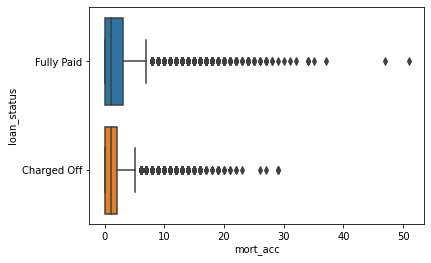

In [48]:
box_plot('mort_acc')

Fill NaN with mean

In [49]:
train['mort_acc'] = train['mort_acc'].fillna(train['mort_acc'].mean())
test['mort_acc'] = test['mort_acc'].fillna(test['mort_acc'].mean())

### `revol_util`

Data Dictionary: Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.

In [50]:
train['revol_util'].describe()

count   1075576.000
mean         51.806
std          24.517
min           0.000
25%          33.500
50%          52.200
75%          70.700
max         892.300
Name: revol_util, dtype: float64

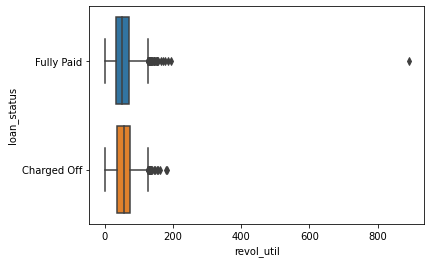

In [51]:
box_plot('revol_util')

There is a outlier for in training dataset. Don't know why this happens. Just fill NaN with mean.

In [52]:
train['revol_util'] = train['revol_util'].fillna(train['revol_util'].mean())
test['revol_util'] = test['revol_util'].fillna(test['revol_util'].mean())

### `pub_rec_bankruptcies`

Data Dictionary: Number of public record bankruptcies

In [53]:
train['pub_rec_bankruptcies'].value_counts(dropna=False).sort_index()

0.000     941468
1.000     126207
2.000       6256
3.000       1270
4.000        322
5.000        114
6.000         38
7.000         10
8.000          7
9.000          3
12.000         1
nan          552
Name: pub_rec_bankruptcies, dtype: int64

Fill NaN with mean.

In [54]:
train['pub_rec_bankruptcies'] = train['pub_rec_bankruptcies'].fillna(train['pub_rec_bankruptcies'].mean())
test['pub_rec_bankruptcies'] = test['pub_rec_bankruptcies'].fillna(test['pub_rec_bankruptcies'].mean())

### `dti`

Data Dictionary: A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.

In [55]:
train['dti'].describe()

count   1075945.000
mean         18.276
std          11.035
min          -1.000
25%          11.790
50%          17.620
75%          24.050
max         999.000
Name: dti, dtype: float64

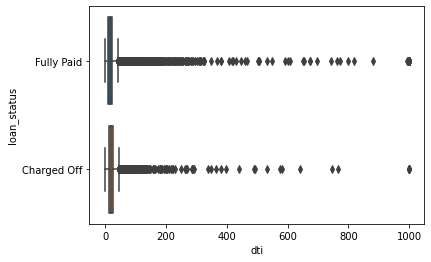

In [56]:
box_plot('dti')

Fill null with mean.

In [57]:
train['dti'] = train['dti'].fillna(train['dti'].mean())
test['dti'] = test['dti'].fillna(test['dti'].mean())

Now take care of **categorical** features with missing data.

In [58]:
# check all the categorical feature's null value
df.select_dtypes('object').isnull().sum().sort_values(ascending=False)

emp_length             78511
zip_code                   1
application_type           0
initial_list_status        0
earliest_cr_line           0
addr_state                 0
purpose                    0
loan_status                0
issue_d                    0
verification_status        0
home_ownership             0
sub_grade                  0
term                       0
dtype: int64

### `emp_length`

Data Dictionary: Employment length in years.

In [59]:
train['emp_length'].value_counts(dropna=False).sort_index()

1 year        70637
10+ years    354019
2 years       97274
3 years       86036
4 years       64396
5 years       67305
6 years       50122
7 years       47768
8 years       48588
9 years       40725
< 1 year      86408
NaN           62970
Name: emp_length, dtype: int64

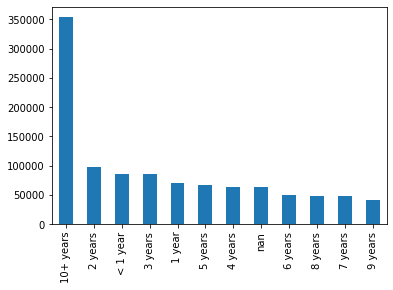

In [60]:
train['emp_length'].value_counts(dropna=False).plot.bar()

Convert `emp_length` to floats and fill NaN with mean.

In [61]:
train['emp_length'].replace('10+ years', '10 years', inplace=True)
train['emp_length'].replace('< 1 year', '0 year', inplace=True)

test['emp_length'].replace('10+ years', '10 years', inplace=True)
test['emp_length'].replace('< 1 year', '0 year', inplace=True)

In [62]:
def emp_length_to_int(year):
  if pd.isnull(year):
    return year
  else:
    return np.int(year.split()[0])

In [63]:
train['emp_length'] = train['emp_length'].apply(emp_length_to_int)
test['emp_length'] = test['emp_length'].apply(emp_length_to_int)

In [64]:
train['emp_length'] = train['emp_length'].fillna(train['emp_length'].mean())
test['emp_length'] = test['emp_length'].fillna(test['emp_length'].mean())

### `zip_code`

Data Dictionary: The first 3 numbers of the zip code provided by the borrower in the loan application.

In [65]:
train['zip_code'].nunique()

935

In [66]:
train.loc[df['zip_code'].isnull()]

,loan_amnt,term,int_rate,installment,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,zip_code,addr_state,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,fico_score
1736050,5600.000,36 months,15.990,196.860,C5,10.000,MORTGAGE,40000.000,Verified,Jan-2017,Fully Paid,debt_consolidation,NaN,AL,22.860,Jul-2005,8.000,1.000,7129.000,68.500,18.000,f,Individual,4.000,1.000,672.000


There is only one borrower whose zipcode is NaN in training and testing. Drop it.

In [67]:
train = train.dropna(subset=['zip_code'])

In [68]:
# Since there are too many zip code to be transform to dummy value, drop it for now
train.drop(columns='zip_code', inplace=True)
test.drop(columns='zip_code', inplace=True)

In [69]:
train.shape

(1076247, 25)

In [70]:
test.shape

(269062, 25)

In [71]:
train.isna().any()

loan_amnt               False
term                    False
int_rate                False
installment             False
sub_grade               False
emp_length              False
home_ownership          False
annual_inc              False
verification_status     False
issue_d                 False
loan_status             False
purpose                 False
addr_state              False
dti                     False
earliest_cr_line        False
open_acc                False
pub_rec                 False
revol_bal               False
revol_util              False
total_acc               False
initial_list_status     False
application_type        False
mort_acc                False
pub_rec_bankruptcies    False
fico_score              False
dtype: bool

In [72]:
test.isna().any()

loan_amnt               False
term                    False
int_rate                False
installment             False
sub_grade               False
emp_length              False
home_ownership          False
annual_inc              False
verification_status     False
issue_d                 False
loan_status             False
purpose                 False
addr_state              False
dti                     False
earliest_cr_line        False
open_acc                False
pub_rec                 False
revol_bal               False
revol_util              False
total_acc               False
initial_list_status     False
application_type        False
mort_acc                False
pub_rec_bankruptcies    False
fico_score              False
dtype: bool

## Part 4.2: Catogorical features

In [73]:
train.dtypes.sort_values()

loan_amnt               float64
mort_acc                float64
total_acc               float64
revol_util              float64
revol_bal               float64
pub_rec                 float64
open_acc                float64
dti                     float64
pub_rec_bankruptcies    float64
fico_score              float64
annual_inc              float64
emp_length              float64
installment             float64
int_rate                float64
loan_status              object
purpose                  object
verification_status      object
earliest_cr_line         object
home_ownership           object
sub_grade                object
initial_list_status      object
application_type         object
term                     object
issue_d                  object
addr_state               object
dtype: object

### `earliest_cr_line`

Data Dictionary: The month the borrower's earliest reported credit line was opened

In [74]:
train['earliest_cr_line'].sample(5)

74926      Dec-2006
255991     Jun-2010
1334155    Aug-1995
1015597    Aug-1987
1059857    Nov-1991
Name: earliest_cr_line, dtype: object

In [75]:
df['earliest_cr_line'].nunique()

739

Let's just retain the year for simplicity:

In [76]:
train['cr_line_year'] = train['earliest_cr_line'].apply(lambda s: int(s[-4:]))
test['cr_line_year'] = test['earliest_cr_line'].apply(lambda s: int(s[-4:]))

In [77]:
train['cr_line_year'].describe([.1, .2, .3, .4, .5, .6, .7, .8, .9])

count   1076247.000
mean       1998.691
std           7.599
min        1944.000
10%        1988.000
20%        1993.000
30%        1996.000
40%        1998.000
50%        2000.000
60%        2002.000
70%        2003.000
80%        2005.000
90%        2007.000
max        2015.000
Name: cr_line_year, dtype: float64

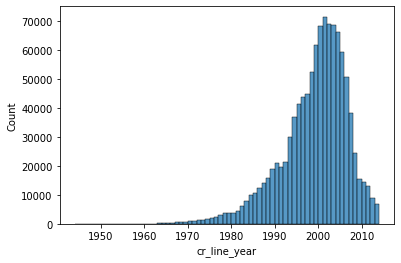

In [78]:
sns.histplot(train['cr_line_year'], bins=range(1944, 2015, 1))

In [79]:
# bin_year = train['cr_line_year'].quantile([.1, .2, .3, .4, .5, .6, .7, .8, .9]).values.astype(int)
# bin_year

In [80]:
train['cr_line_year'].dtypes

dtype('int64')

In [81]:
# all_bin_year = [train['cr_line_year'].min()]
# all_bin_year.extend(bin_year)
# all_bin_year.append(train['cr_line_year'].max())
# all_bin_year

In [82]:
# # make year range labels
# year_range = []
# for i in range(len(all_bin_year) - 1):
#   year = '{}-{}'.format(all_bin_year[i], all_bin_year[i+1])
#   year_range.append(year)
# year_range

In [83]:
# train['cr_line_year_bin'] = pd.cut(train['cr_line_year'], all_bin_year, labels=year_range)
# test['cr_line_year_bin'] = pd.cut(test['cr_line_year'], all_bin_year, labels=year_range)
train.drop(columns=['earliest_cr_line'], inplace=True)
test.drop(columns=['earliest_cr_line'], inplace=True)
train.head()

,loan_amnt,term,int_rate,installment,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,addr_state,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,fico_score,cr_line_year
1959284,36750.000,60 months,22.390,1023.170,E1,9.000,MORTGAGE,84000.000,Verified,Sep-2016,Fully Paid,debt_consolidation,IN,25.130,13.000,5.000,19109.000,53.700,18.000,w,Joint App,1.000,0.000,712.000,2001
388387,10000.000,36 months,11.440,329.480,B4,5.000,RENT,50000.000,Source Verified,Jan-2015,Fully Paid,credit_card,FL,6.700,5.000,1.000,6716.000,79.000,8.000,f,Individual,0.000,1.000,667.000,2005
700527,4200.000,36 months,9.750,135.030,B3,5.969,MORTGAGE,49200.000,Source Verified,May-2016,Fully Paid,home_improvement,AL,3.240,3.000,0.000,5504.000,54.500,6.000,f,Individual,3.000,0.000,782.000,2000
2138115,6000.000,36 months,14.080,205.300,C3,5.969,OWN,18720.000,Source Verified,Oct-2017,Fully Paid,debt_consolidation,MO,9.100,4.000,1.000,4787.000,68.400,6.000,w,Individual,1.000,1.000,662.000,2000
203873,7650.000,36 months,14.650,263.890,C5,1.000,OWN,40000.000,Not Verified,Jul-2015,Charged Off,home_improvement,KS,14.400,7.000,1.000,1849.000,24.000,28.000,f,Individual,6.000,1.000,672.000,1992


### `issue_d`

Data Dictionary: The month which the loan was funded.

Take care of it similar to `earliest_cr_line`

In [84]:
train['issue_d'].sample(5)

209306     Jul-2015
296935     May-2015
1201187    Sep-2014
1523949    May-2018
1326622    Feb-2014
Name: issue_d, dtype: object

In [85]:
train['issue_year'] = train['issue_d'].apply(lambda s: int(s[-4:]))
test['issue_year'] = test['issue_d'].apply(lambda s: int(s[-4:]))
train['issue_year'].value_counts().sort_index()

2007       197
2008      1253
2009      3788
2010      9235
2011     17415
2012     42952
2013    107625
2014    178399
2015    300524
2016    234612
2017    135319
2018     44928
Name: issue_year, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


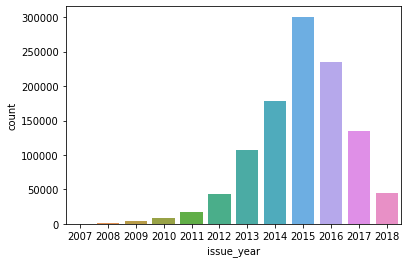

In [86]:
sns.countplot(train['issue_year'])

In [87]:
train = train.drop(columns='issue_d')
test = test.drop(columns='issue_d')

### `home_ownership`

In [88]:
train['home_ownership'].value_counts()

MORTGAGE    532817
RENT        427235
OWN         115803
ANY            230
OTHER          123
NONE            39
Name: home_ownership, dtype: int64

Replace the values `ANY` and `NONE` with `OTHER`:

In [89]:
train['home_ownership'].replace(['NONE', 'ANY'], 'OTHER', inplace=True)
test['home_ownership'].replace(['NONE', 'ANY'], 'OTHER', inplace=True)

### One Hot Encoding

Take care of target feature:

In [90]:
train['loan_status'] = (train['loan_status'] == 'Charged Off').astype(int)
test['loan_status'] = (test['loan_status'] == 'Charged Off').astype(int)

In [91]:
train['loan_status'].value_counts()

0    861400
1    214847
Name: loan_status, dtype: int64

In [92]:
test['loan_status'].value_counts()

0    215350
1     53712
Name: loan_status, dtype: int64

Occasionaly, training and testing contain different feature cardinality (e.g. State). So we can't use get_dummy to do the one hot encoding. We use OneHotEncoder here:


In [93]:
cat_cols = train.columns[(train.dtypes == 'O')]

In [94]:
cat_cols

Index(['term', 'sub_grade', 'home_ownership', 'verification_status', 'purpose',
       'addr_state', 'initial_list_status', 'application_type'],
      dtype='object')

In [95]:
from sklearn.preprocessing import OneHotEncoder

def OneHotEncoding(df, encoder, cols):
  transformed = pd.DataFrame(encoder.transform(df[cols]).toarray(), columns=encoder.get_feature_names(cols))
  return pd.concat([df.reset_index(drop=True), transformed], axis=1).drop(cat_cols, axis=1)

### Undersampling

In [96]:
default_train_undersampling = train.loc[train['loan_status'] == 1]

In [97]:
non_default_train_undersampling = train.loc[train['loan_status'] == 0].sample(n=214847, random_state=42)

In [98]:
train_undersampling = pd.concat([default_train_undersampling, non_default_train_undersampling])

In [99]:
X_train_undersampling = train_undersampling.drop(columns='loan_status')
X_test_undersampling = test.drop(columns='loan_status')

y_train_undersampling = train_undersampling['loan_status']
y_test_undersampling = test['loan_status']

In [128]:
test.head()

,loan_amnt,term,int_rate,installment,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,addr_state,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,fico_score,cr_line_year,issue_year
1348824,17000.000,36 months,6.620,521.970,A2,8.000,MORTGAGE,60000.000,Verified,0,credit_card,FL,20.480,10.000,0.000,15290.000,39.700,21.000,f,Individual,2.000,0.000,757.000,2001,2014
1802011,10025.000,36 months,15.880,351.860,C4,8.000,MORTGAGE,115000.000,Not Verified,0,credit_card,GA,16.990,11.000,0.000,18298.000,80.300,38.000,f,Individual,5.000,0.000,687.000,2001,2013
1231957,33425.000,36 months,12.490,1118.030,B5,3.000,RENT,115000.000,Verified,0,debt_consolidation,NY,18.340,9.000,0.000,9810.000,61.300,31.000,w,Individual,0.000,0.000,697.000,2000,2014
1641941,2000.000,36 months,15.700,70.020,D4,10.000,MORTGAGE,66000.000,Not Verified,0,medical,OH,9.130,8.000,0.000,23176.000,97.000,23.000,f,Individual,1.666,0.000,662.000,1996,2010
1143375,6800.000,36 months,15.990,239.040,D2,1.000,RENT,20000.000,Source Verified,1,debt_consolidation,RI,22.570,7.000,0.000,13635.000,55.000,9.000,f,Individual,0.000,0.000,682.000,2006,2014


In [100]:
enc = OneHotEncoder()
enc.fit(X_train_undersampling[cat_cols])

X_train_undersampling = OneHotEncoding(X_train_undersampling, enc, cat_cols)
X_test_undersampling = OneHotEncoding(X_test_undersampling, enc, cat_cols)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [101]:
y_train_undersampling.value_counts()

1    214847
0    214847
Name: loan_status, dtype: int64

### Oversampling

In [1]:
X_train_oversampling = train.drop(columns='loan_status')
X_test_oversampling = test.drop(columns='loan_status')

y_train_oversampling = train['loan_status']
y_test_oversampling = test['loan_status']

NameError: ignored

In [103]:
enc = OneHotEncoder()
enc.fit(X_train_oversampling[cat_cols])

X_train_oversampling = OneHotEncoding(X_train_oversampling, enc, cat_cols)
X_test_oversampling = OneHotEncoding(X_test_oversampling, enc, cat_cols)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=12)
X_train_sm, y_train_sm = smote.fit_resample(X_train_oversampling, y_train_oversampling)

In [658]:
y_train_sm.value_counts()

1    38045
0    38045
Name: loan_status, dtype: int64

## Part 4.3: Data Standardize

We use standard scaling

In [106]:
num_cols = X_train_undersampling.columns[(X_train_undersampling.dtypes == 'float64') | (X_train_undersampling.dtypes == 'int64')]

In [107]:
scaler = StandardScaler()
scaler.fit(X_train_undersampling[num_cols])
X_train_undersampling[num_cols] = scaler.transform(X_train_undersampling[num_cols])
X_test_undersampling[num_cols] = scaler.transform(X_test_undersampling[num_cols])

In [664]:
scaler = StandardScaler()
scaler.fit(X_train_sm[num_cols])
X_train_sm[num_cols] = scaler.transform(X_train_sm[num_cols])
X_test_oversampling[num_cols] = scaler.transform(X_test_oversampling[num_cols])

# Part 5: Model Training

The algorithm we will use here:


*   Random Forest
*   XGBoost
*   ANN



In [102]:
# helper function for printing out grid search results
def gs_results(gs):
  print('Best score: ' + str(gs.best_score_))
  print('Best parameters: ')
  best_params = gs.best_params_
  for param in best_params.keys():
    print('\t\t' + param + ': ' + str(best_params[param]))

## Part 5.1: Logistic Regression

In [103]:
clf_lr = LogisticRegression()

In [104]:
# C = 1/lambda
lr_params = {
    'C':(10, 100),
    'max_iter': [100, 250]
}

In [108]:
Grid_LR = GridSearchCV(clf_lr, param_grid=lr_params, scoring='recall', verbose=3)
Grid_LR.fit(X_train_undersampling, y_train_undersampling)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ................C=10, max_iter=100;, score=0.679 total time=   6.2s
[CV 2/5] END ................C=10, max_iter=100;, score=0.679 total time=   6.0s
[CV 3/5] END ................C=10, max_iter=100;, score=0.679 total time=   6.3s
[CV 4/5] END ................C=10, max_iter=100;, score=0.675 total time=   5.9s
[CV 5/5] END ................C=10, max_iter=100;, score=0.680 total time=   6.7s
[CV 1/5] END ................C=10, max_iter=250;, score=0.679 total time=   5.9s
[CV 2/5] END ................C=10, max_iter=250;, score=0.679 total time=   6.8s
[CV 3/5] END ................C=10, max_iter=250;, score=0.679 total time=   6.3s
[CV 4/5] END ................C=10, max_iter=250;, score=0.675 total time=   5.9s
[CV 5/5] END ................C=10, max_iter=250;, score=0.680 total time=   6.6s
[CV 1/5] END ...............C=100, max_iter=100;, score=0.679 total time=   5.8s
[CV 2/5] END ...............C=100, max_iter=100;,

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': (10, 100), 'max_iter': [100, 250]},
             scoring='recall', verbose=3)

In [109]:
gs_results(Grid_LR)

Best score: 0.6786178000946969
Best parameters: 
		C: 10
		max_iter: 100


In [110]:
# best model
best_lr_model = Grid_LR.best_estimator_

In [143]:
print(classification_report(y_test_undersampling, best_lr_model.predict(X_test_undersampling)))

              precision    recall  f1-score   support

           0       0.89      0.63      0.74    215350
           1       0.31      0.68      0.43     53712

    accuracy                           0.64    269062
   macro avg       0.60      0.66      0.58    269062
weighted avg       0.77      0.64      0.68    269062



In [111]:
from sklearn.metrics import roc_auc_score

lr_auc = roc_auc_score(y_test_undersampling, best_lr_model.predict(X_test_undersampling))
lr_auc

0.6551968293228133

## Part 5.2: Random Forest

In [112]:
clf_rf = RandomForestClassifier(random_state=0, n_jobs=-1)

In [113]:
rf_params = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20]
}

In [114]:
Grid_RF = GridSearchCV(clf_rf, param_grid=rf_params, scoring='recall', verbose=3)
Grid_RF.fit(X_train_undersampling, y_train_undersampling)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END .....max_depth=10, n_estimators=50;, score=0.677 total time=  29.4s
[CV 2/5] END .....max_depth=10, n_estimators=50;, score=0.676 total time=  32.8s
[CV 3/5] END .....max_depth=10, n_estimators=50;, score=0.678 total time=  23.9s
[CV 4/5] END .....max_depth=10, n_estimators=50;, score=0.673 total time=  24.4s
[CV 5/5] END .....max_depth=10, n_estimators=50;, score=0.673 total time=  24.2s
[CV 1/5] END ....max_depth=10, n_estimators=100;, score=0.678 total time=  46.1s
[CV 2/5] END ....max_depth=10, n_estimators=100;, score=0.682 total time=  46.6s
[CV 3/5] END ....max_depth=10, n_estimators=100;, score=0.681 total time=  46.6s
[CV 4/5] END ....max_depth=10, n_estimators=100;, score=0.673 total time=  46.2s
[CV 5/5] END ....max_depth=10, n_estimators=100;, score=0.676 total time=  46.7s
[CV 1/5] END .....max_depth=20, n_estimators=50;, score=0.678 total time=  47.0s
[CV 2/5] END .....max_depth=20, n_estimators=50;,

GridSearchCV(estimator=RandomForestClassifier(n_jobs=-1, random_state=0),
             param_grid={'max_depth': [10, 20], 'n_estimators': [50, 100]},
             scoring='recall', verbose=3)

In [115]:
gs_results(Grid_RF)

Best score: 0.6791251390228652
Best parameters: 
		max_depth: 20
		n_estimators: 100


In [116]:
# best model
best_rf_model = Grid_RF.best_estimator_

In [113]:
best_rf_model.score(X_test_undersampling, y_test_undersampling)  # accuracy score = tp / total

0.6456058454928604

In [114]:
accuracy_score(y_test_undersampling, best_rf_model.predict(X_test_undersampling))

0.6456058454928604

In [115]:
f1_score(y_test_undersampling, best_rf_model.predict(X_test_undersampling))

0.4347248734334799

In [116]:
recall_score(y_test_undersampling, best_rf_model.predict(X_test_undersampling))

0.6826407506702413

In [117]:
precision_score(y_test_undersampling, best_rf_model.predict(X_test_undersampling))

0.3189068832953537

In [ ]:
print(classification_report(y_test_undersampling, best_rf_model.predict(X_test_undersampling)))

In [118]:
confusion_matrix(y_test_undersampling, best_rf_model.predict(X_test_undersampling))

array([[137042,  78308],
       [ 17046,  36666]])

##Smote 

In [134]:
#@title
clf_rf = RandomForestClassifier(random_state=0, n_jobs=-1)

In [ ]:
#@title
rf_params = {
    'n_estimators': [5, 10],
    'max_depth': [10, 20]
}

In [ ]:
#@title
Grid_RF = GridSearchCV(clf_rf, param_grid=rf_params, scoring='recall', verbose=3)
Grid_RF.fit(X_train_sm, y_train_sm)

In [ ]:
#@title
gs_results(Grid_RF)

In [ ]:
#@title
# best model
best_rf_model = Grid_RF.best_estimator_

In [ ]:
#@title
best_rf_model.score(X_test_oversampling, y_test_oversampling)  # accuracy score = tp / total

In [ ]:
#@title
accuracy_score(y_test_oversampling, best_rf_model.predict(X_test_oversampling))

In [ ]:
#@title
f1_score(y_test_oversampling, best_rf_model.predict(X_test_oversampling))

In [ ]:
#@title
recall_score(y_test_oversampling, best_rf_model.predict(X_test_oversampling))

In [ ]:
#@title
precision_score(y_test_oversampling, best_rf_model.predict(X_test_oversampling))

In [ ]:
#@title
confusion_matrix(y_test_oversampling, best_rf_model.predict(X_test_oversampling))

## Part 5.3: XGBoost

In [105]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', 
                            eval_metric="logloss", ## this avoids a warning...
                            seed=42, 
                            use_label_encoder=False)

In [108]:
parameters = {
    'n_estimators': [100],
    'max_depth': [5],
    'gamma': [0.25],
    'reg_lambda': [10]
}

In [111]:
Grid_XGBoost = GridSearchCV(clf_xgb,parameters, scoring='recall', verbose=3)
Grid_XGBoost.fit(X_train_undersampling, 
                 y_train_undersampling,
                 early_stopping_rounds=10,                
                 eval_metric='aucpr',
                 eval_set=[(X_test_undersampling, y_test_undersampling)])

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[0]	validation_0-aucpr:0.35457
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.358826
[2]	validation_0-aucpr:0.360172
[3]	validation_0-aucpr:0.363266
[4]	validation_0-aucpr:0.364769
[5]	validation_0-aucpr:0.366647
[6]	validation_0-aucpr:0.370448
[7]	validation_0-aucpr:0.371375
[8]	validation_0-aucpr:0.373146
[9]	validation_0-aucpr:0.37361
[10]	validation_0-aucpr:0.374846
[11]	validation_0-aucpr:0.375918
[12]	validation_0-aucpr:0.376679
[13]	validation_0-aucpr:0.377128
[14]	validation_0-aucpr:0.378609
[15]	validation_0-aucpr:0.379601
[16]	validation_0-aucpr:0.380188
[17]	validation_0-aucpr:0.380706
[18]	validation_0-aucpr:0.381519
[19]	validation_0-aucpr:0.382293
[20]	validation_0-aucpr:0.382505
[21]	validation_0-aucpr:0.382929
[22]	validation_0-aucpr:0.383667
[23]	validation_0-aucpr:0.384221
[24]	validation_0-aucpr:0.384574
[25]	validation_0-aucpr:0.385131
[26]	validation_0-aucpr:0.385

GridSearchCV(estimator=XGBClassifier(),
             param_grid={'gamma': [0.25], 'max_depth': [5],
                         'n_estimators': [100], 'reg_lambda': [10]},
             scoring='recall', verbose=3)

In [112]:
gs_results(Grid_XGBoost)

Best score: 0.6766536069893341
Best parameters: 
		gamma: 0.25
		max_depth: 5
		n_estimators: 100
		reg_lambda: 10


In [113]:
best_xgb_model = Grid_XGBoost.best_estimator_

In [116]:
from sklearn.metrics import classification_report
print(classification_report(y_test_undersampling, best_xgb_model.predict(X_test_undersampling)))

              precision    recall  f1-score   support

           0       0.89      0.65      0.75    215350
           1       0.32      0.68      0.44     53712

    accuracy                           0.65    269062
   macro avg       0.61      0.66      0.59    269062
weighted avg       0.78      0.65      0.69    269062



In [117]:
best_xgb_model.score(X_test_undersampling, y_test_undersampling)  # accuracy score = tp / total

0.6531431417294156

In [118]:
accuracy_score(y_test_undersampling, best_xgb_model.predict(X_test_undersampling))

0.6531431417294156

In [119]:
f1_score(y_test_undersampling, best_xgb_model.predict(X_test_undersampling))

0.43918707785496236

In [120]:
recall_score(y_test_undersampling, best_xgb_model.predict(X_test_undersampling))

0.6803507596067918

In [121]:
precision_score(y_test_undersampling, best_xgb_model.predict(X_test_undersampling))

0.32425022182786156

# Part 6: Feature Importance

In [117]:
importances = best_rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

In [119]:
# Print the feature ranking
print("Feature importance ranking by Random Forest Model:")
for ind in range(X_train_undersampling.shape[1]):
  print ("{0} : {1}".format(X_train_undersampling.columns[indices[ind]],round(importances[indices[ind]], 4)))

Feature importance ranking by Random Forest Model:
int_rate : 0.1529
dti : 0.0589
fico_score : 0.0535
annual_inc : 0.0452
installment : 0.0442
term_ 60 months : 0.0421
revol_bal : 0.041
term_ 36 months : 0.0407
revol_util : 0.04
loan_amnt : 0.0367
cr_line_year : 0.0322
total_acc : 0.0322
issue_year : 0.0321
open_acc : 0.0286
mort_acc : 0.0258
emp_length : 0.0217
verification_status_Not Verified : 0.0131
sub_grade_A1 : 0.0116
home_ownership_MORTGAGE : 0.0108
home_ownership_RENT : 0.0092
sub_grade_A5 : 0.0085
sub_grade_A4 : 0.0077
sub_grade_A2 : 0.0075
pub_rec : 0.0068
verification_status_Verified : 0.0067
sub_grade_A3 : 0.0067
purpose_debt_consolidation : 0.0057
verification_status_Source Verified : 0.0054
purpose_credit_card : 0.0053
initial_list_status_f : 0.0051
initial_list_status_w : 0.005
pub_rec_bankruptcies : 0.0048
addr_state_CA : 0.0046
sub_grade_B2 : 0.0045
sub_grade_B1 : 0.0044
sub_grade_B3 : 0.004
sub_grade_B4 : 0.0039
sub_grade_B5 : 0.0038
sub_grade_C1 : 0.0038
addr_state_

# Part 7: Expected Loss

Expected Loss (EL) on a given is calculuated using the loan amount multiplied by a loan's probability of default (PD) mulitplied by the the loan's loss given default (LGD). Loss Given Default is the amount of the loan that is deemed unrecoverable and is represented as a number between 0 (no loss) and 1 (100% of the loan is a loss)

The equation for EL is given as:

* EL = PD x LGD x Loan Amount

With proabilties of default we will then model Expected Loss using an assumed LGD of 1 (a LGD of 1 is a conservative assumption given the unsecured nature of the loans)

In [120]:
lr_preds = best_lr_model.predict_proba(X_test_undersampling)
rf_preds = best_rf_model.predict_proba(X_test_undersampling)
xgb_preds = best_xgb_model.predict_proba(X_test_undersampling)

In [139]:
loss_df = pd.DataFrame(lr_preds[:, 1], columns=['lr_default_prob'])
loss_df['rf_default_prob'] = rf_preds[:, 1]
loss_df['xgb_default_prob'] = xgb_preds[:, 1]
loss_df['lgb'] = 1
loss_df.index = test.index
loss_df['loan_amnt'] = test['loan_amnt']
loss_df.head()

,lr_default_prob,rf_default_prob,lgb,loan_amnt
1348824,0.154,0.149,1,17000.000
1802011,0.295,0.342,1,10025.000
1231957,0.505,0.462,1,33425.000
1641941,0.431,0.399,1,2000.000
1143375,0.596,0.565,1,6800.000


In [141]:
loss_df['lr_expected_loss'] = loss_df['lr_default_prob'] * loss_df['lgb'] * loss_df['loan_amnt']
loss_df['rf_expected_loss'] = loss_df['rf_default_prob'] * loss_df['lgb'] * loss_df['loan_amnt']
loss_df['xgb_expected_loss'] = loss_df['xgb_default_prob'] * loss_df['lgb'] * loss_df['loan_amnt']

In [143]:
# Print the total portfolio size
print('Portfolio size: $' + "{:,.2f}".format(np.sum(loss_df['loan_amnt'])))

# Print the sum of the expected loss for lr
print('lr expected loss: $' + "{:,.2f}".format(np.sum(loss_df['lr_expected_loss'])))

# Print the sum of the expected loss for rf
print('rf expected loss: $' + "{:,.2f}".format(np.sum(loss_df['rf_expected_loss'])))

# Print the sum of the expected loss for xgb
print('xgb expected loss: $' + "{:,.2f}".format(np.sum(loss_df['xgb_expected_loss'])))

Portfolio size: $3,882,719,725.00
lr expected loss: $1,857,781,224.38
rf expected loss: $1,855,605,497.96
